## Modelling with Universal Sentence Encoder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow_hub as hub

import re
import nltk
import string
from textblob import TextBlob

%config InlineBackend.figure_format='retina'

This notebook demontrates the use of [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder) <b>(USE)</b> which is made open source by [TensorFlow Hub](https://tfhub.dev) .



[Link to download USE from TensorFlow Hub local source](https://tfhub.dev/google/universal-sentence-encoder/4)






In [2]:
# Loads Universal Sentence Encoder from TensorFlow Hub online source
#embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

# Loads Universal Sentence Encoder from TensorFlow Hub local source

embed = hub.load("/Users/data/universal-sentence-encoder_4")



### How USE works

According to USE website, "The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks."

Additionally, "The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks". Therefore, it's very critical since we want to cluster for the corpora of vitamin product reviews with sentence similarity.

references: [TensorFlow Hub](https://tfhub.dev)

The encoder works with the progress as below:

    1. Tokenizes the sentences after converting them to lowcase.
    2. Variable length English text is converted to a 512-dimentional vector:
    3. These sentence embeddings are then used for various unsupervised or supervised tasks.
    
references: [Top 4 Sentence Embedding Techniques using Python!](https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/)

In [4]:
# Example:

sentences_example = "A good combination of vitamin D and vitamin K, I recommend to everyone"
embed_example = embed([sentences_example])

embed_example.shape

TensorShape([1, 512])

We can see the USE encodes the sentence into a 512-dimensional vector.

### Semantic Similarity

<img src = "https://docs.google.com/uc?export=download&id=1FgH7ofnRiEgM1GYRnBfsjdAOLTZY3buB" />


Since the sentences are preprocessed by USE as the way that sematically similar sentences are put into similar location in the 512-dimensional space. And the closer the inner sentences to 1, the more semantically similar they are.


### Classification

<img src = "https://docs.google.com/uc?export=download&id=1bdYaV9rSby3fn5XCU_Ctuf8av-iF3yHq" />


references: [TensorFlow Hub](https://tfhub.dev)
    


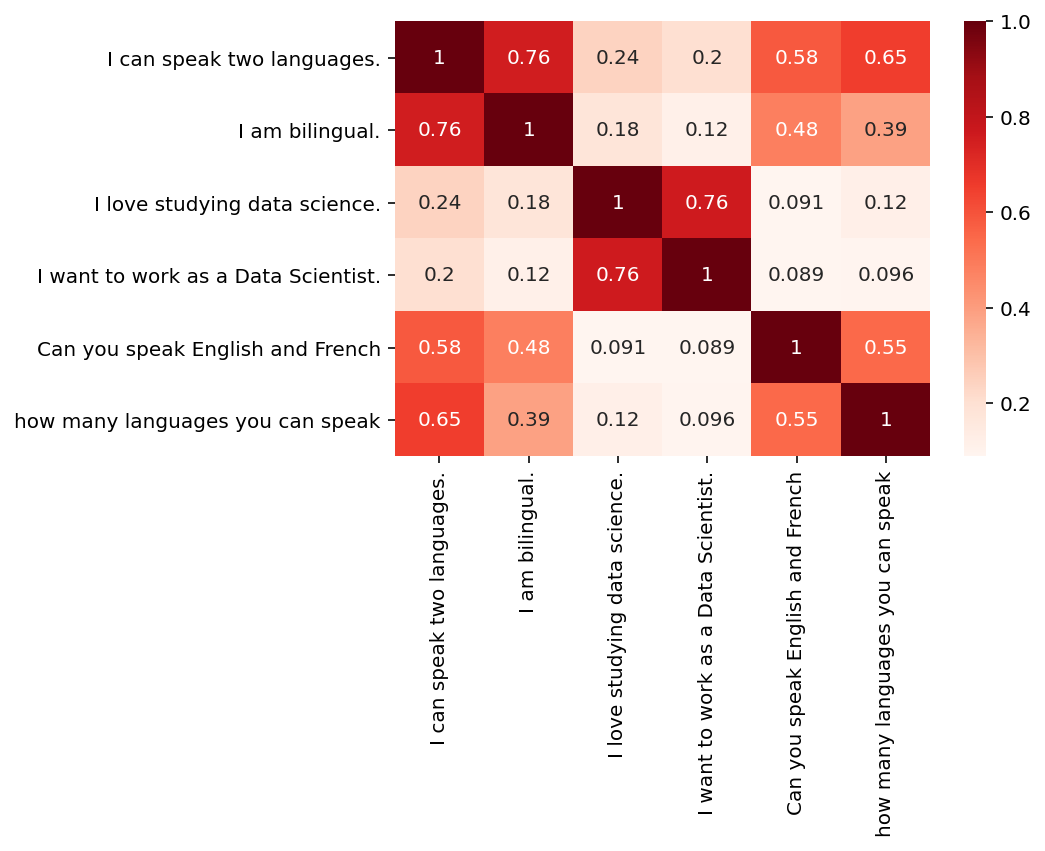

In [5]:
# Some sample sentences
sentence_1 = "I can speak two languages."
sentence_2 = "I am bilingual."
sentence_3 = "I love studying data science."
sentence_4 = "I want to work as a Data Scientist."
sentence_5 = "Can you speak English and French"
sentence_6 = "how many languages you can speak"
sample_sentences = [sentence_1, sentence_2, sentence_3, sentence_4,sentence_5,sentence_6]

# Vectorize sentences
sample_vectors = embed(sample_sentences)

# Take the inner product of the sentence vectors
samples = np.inner(sample_vectors, sample_vectors)

# Visualize the inner products with a heatmap
plt.figure()
sns.heatmap(samples, annot=True, xticklabels=sample_sentences, yticklabels=sample_sentences, cmap="Reds")
plt.show()

### Applying USE in GoodVitamins

To illustrate the use of USE in terms of classifying the most commonly perspectives accross the vitamin product reviews, we will be working on an example of a vitamin product: <b>`Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps`</b> .

<img src = "https://docs.google.com/uc?export=download&id=1xFdWjxVs0vjFNeQgKzVifSHUHQhqY6N_" />


In [3]:
# Loads the original dataset

df = pd.read_csv(r'/Users/quanganhpham/Downloads/github_capstone/data/iherb_best_selling_products_clean_dataset.csv') 

df.head(2)

,item_image_link,item_brand,item_name,item_description,item_price,total_rating,review_contents,individual_rating,product_helpful,product_not_helpful,product_id,brand_id
0,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,I bought it because of good caustic vitamin C ...,5,3136,64,49,2
1,https://s3.images-iherb.com/cgn/cgn00931/l/115...,California Gold Nutrition,"Gold C, Vitamin C, 1,000 mg, 60 Veggie Capsules","California Gold Nutrition Gold C™, 1000 mg, Fe...",6.56,4.7,With such preparation as ascorbic acid or vita...,5,2271,125,49,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17271 entries, 0 to 17270
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   item_image_link      17271 non-null  object 
 1   item_brand           17271 non-null  object 
 2   item_name            17271 non-null  object 
 3   item_description     17271 non-null  object 
 4   item_price           17271 non-null  float64
 5   total_rating         17271 non-null  float64
 6   review_contents      17271 non-null  object 
 7   individual_rating    17271 non-null  int64  
 8   product_helpful      17271 non-null  int64  
 9   product_not_helpful  17271 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 1.3+ MB


In [8]:
df.shape

(17271, 10)

#### Filtering out other products and keeping only the review contents of product `Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps` :

In [4]:
product_review = df['review_contents'].loc[df['item_name'] == 'Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps'].reset_index(drop=True).copy()

In [5]:
# list numbers of unique review contents from all the rows:
print(f'This dataset consists of {product_review.shape[0]} sentences from {product_review.nunique()} reviews\n')

This dataset consists of 142 sentences from 142 reviews



Checking the most semantically similar review contents to a random review content for this product:

In [11]:
# Vectorize the "product_review":
review_vectors = embed(product_review)

# Take a random sentence from the "product_review"
random_index = 11
sample_sentence = product_review.loc[random_index]

# Get the inner product of the review content and all other review contents in the "product_review"
sample_vector = review_vectors[random_index]
sample_ips = np.inner(sample_vector, review_vectors)

# Find the review contents with the highest inner product
top_five_sentences = pd.Series(sample_ips).nlargest(6)
top_five_indices = top_five_sentences.index
top_five_list = product_review[top_five_indices][1:] # starts from 1 so it won't show the same sentences of the sample review

print(f'Review Sample: "{sample_sentence}"\n')
print(f'Five most semantically similar review contents in the dataset:\n')
print(*top_five_list, sep='\n''\n')

Review Sample: "Working vitamin D in good dosage fortified with vitamin Of for better and proper absorption. Maintains vitamin D levels at the required levels. Constant purchase I take a small jar then a large one which is available at the time of purchase"

Five most semantically similar review contents in the dataset:

A good vitamin of a well-known brand. Comes together with Of of in order for vitamin D to be absorbed at a dosage of 5000 of and more Of is needed

A good drug because it hoped with the task. I needed to raise my vitamin D levels. After two months my blood counts improved. Vitamin D from 16 left at 48. I will continue to drink the dosage is good.

It first the doctor prescribed 10000 units to drink because according to the analyze it was very low. When I raised my vitamin D thanks to this particular vitamin in combination with other dietary supplement and meditations I actually got more energy. Now I drink one capsule every morning after breakfast to maintain my vitami

#### We could see the promising results from the model. The main theme here is from the users who want to improve the vitamin D3 level in their blood; Therefore, they decided to buy the product to cope with the Vitamin D3 deficiency and got the good result after using the product for a while.
#### However, the first review is pretty short which is not symmetric with the review sample but it does have same verb "drink" with the sample. Additionally, the third review seems not quite similar to the sample but we could see the subtle equivalent in terms of the compliment of taking this vitamin "in the autumn-winter".

### Clustering the most common perspectives.

We know that USE's concept is to <b>`classify the sentences with similar meanings and place them to similar locations`</b>. Technically, USE encodes the sentences into 512-dimensional vector space where the semantically similar sentences are placed in the same region. Therefore, the semantically sentences are formed into different clusters in that high dimensional vector space.

Our main goal here is to find the <b>`different perspectives of the users`</b> and their experiences about the products from the review contents. With the help of k-means clustering, we can quickly locate the regions of the clusters which are the different perspectives of the users.

"Clustering is the process of dividing the entire data into groups (also known as clusters) based on the patterns in the data. In clustering, we do not have a target to predict. We look at the data and then try to club similar observations and form different groups. Hence it is an unsupervised learning problem."

With our main goal and the dataset as the review contents, Kmeans Clustering can bring a valid solution which can cluster the different perspectives of the users through the semantically data points.

references: [The Most Comprehensive Guide to K-Means Clustering You’ll Ever Need](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/)


In [6]:
# Set numbers for clusters (k) and numbers of review to display (n):

k= 4
n= 5

# Vectorize the "product_review":
review_vectors = embed(product_review)

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(review_vectors)


# Loop through number of clusters
for i in range(k):
    
    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]
    
    # Calculate inner product of cluster centre and review vectors
    inner_product_cluster = np.inner(centre, review_vectors)
    
    # Find the sentences with the highest inner products
    top_indices = pd.Series(inner_product_cluster).nlargest(n).index
    top_sentences = product_review[top_indices]
    
    print(f'Cluster #{i+1} reviews:\n')
    print(*top_sentences, sep='\n''\n')
    print('\n')

Cluster #1 reviews:

It first the doctor prescribed 10000 units to drink because according to the analyze it was very low. When I raised my vitamin D thanks to this particular vitamin in combination with other dietary supplement and meditations I actually got more energy. Now I drink one capsule every morning after breakfast to maintain my vitamin D.

Everyone around said that in Russia everyone especially in winter should drink vitamin D. But I decided not to believe in a word and check my level of vitamin D in the laboratory. The result was so-so though not quite critical - 38. I decided to raise D to the maximum value because it is necessary for bones hair immunity cancer prevention good mood and much more. The ordered this drug and drank it for 2 months basically drank 2 tablets a day sometimes 4 you can take such doses every day and only if you passed the tests and you know exactly what vitamin D you have where to raise. 2 month new test results showed 90. I'm happy the drug is 10

From the 4 clusters above, we can see that the Kmeans Clustering algorithm has worked so hard to give us the promising result.

`cluster 1` : seems to come from knowledgable users who have a solid experience with the product and also got a sigficant result after using it for a particular period of time.

`cluster 2` : from the users who have realized the benefits of the product which consists of vitamin D3 and vitamin K.

`cluster 3` : is a pretty bit similar with cluster 2. However, the reviews seem like from the users who wanted to buy for their family members or themselves with the hope of improving their health condition.

`cluster 4` : contains pretty short and concise contents.

#### We may see some broken english sentences because of the automated machine translator which translated all the reviews contents from different languages to English. We have to be mindful of this issue and try to understand the main theme through the context of the review contents.

#### Let's try product `Vitamin C Gummies, Natural Orange Flavor, Gelatin Free, 90 Gummies`

<img src = "https://docs.google.com/uc?export=download&id=1WExX9J3m5Nmk-gjYCB6ePicrO0dpZzrO" />

In [13]:
product_review = df['review_contents'].loc[df['item_name'] == 'Vitamin C Gummies, Natural Orange Flavor, Gelatin Free, 90 Gummies'].reset_index(drop=True).copy()

inner_product_cluster

array([0.10092026, 0.07383548, 0.28100259, 0.0486042 , 0.24398895,
       0.04601228, 0.28518094, 0.12386996, 0.13563904, 0.148726  ,
       0.04434471, 0.11806919, 0.13201386, 0.12491245, 0.17968194,
       0.15763078, 0.09560685, 0.16779227, 0.18872763, 0.18368663,
       0.111113  , 0.09079789, 0.10122701, 0.08749275, 0.08570596,
       0.12707553, 0.11548229, 0.0685935 , 0.14410168, 0.11689271,
       0.02429428, 0.0680497 , 0.2154265 , 0.05008736, 0.02441551,
       0.20286242, 0.13542338, 0.15208121, 0.14454511, 0.08441876,
       0.16566383, 0.07200024, 0.051748  , 0.15327643, 0.11310513,
       0.14988398, 0.14053974, 0.09099832, 0.16391277, 0.08935358,
       0.25415131, 0.10453268, 0.20450528, 0.17506589, 0.19733775,
       0.16862954, 0.19870724, 0.17908905, 0.09483125, 0.27854018,
       0.18944007, 0.10010697, 0.18331181, 0.21895745, 0.13353915,
       0.17775937, 0.18341636, 0.18174128, 0.20815534, 0.09353884,
       0.166066  , 0.19975383, 0.06765356, 0.26005337, 0.19772

In [14]:
k= 4
n= 6

# Vectorize the "product_review":
review_vectors = embed(product_review)

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(review_vectors)


# Loop through number of clusters
for i in range(k):
    
    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]
    
    # Calculate inner product of cluster centre and sentence vectors
    inner_product_cluster = np.inner(centre, review_vectors)
    
    # Find the sentences with the highest inner products
    top_indices = pd.Series(inner_product_cluster).nlargest(n).index
    top_sentences = product_review[top_indices]
    
    print(f'Cluster #{i+1} reviews:\n')
    print(*top_sentences, sep='\n''\n')
    print('\n')

Cluster #1 reviews:

Delicious healthy. By children enjoy eating.

Children are very receptive adults will feel too sweet to eat

Children eat with pleasure the dosage is moderate which pleases

very taste vitamin children are happy and act with cold

Chewing candy is something that children eat with pleasure. Therefore I recommend.

Tastes like marmalade is liked by both adults and children.


Cluster #2 reviews:

A very good vitamin The taste is wonderful the children like both the shape and taste. I am completely satisfied with the composition and the great price

It was a kiss gumma but since I was 4 years old I didn't let my daughter eat it It is not too sweet and easy to eat. Repeat

He decided to try chewing vitamin they taste good with an orange flavor the child liked it

It's delicious and I eat it like a sweet. It tastes like oranges.

It has a lot of quantity and tastes good. I have to eat it after meals so I don’t feel sick.

I took it for the child but I eat it myself. Unr

We can see some paterns from 4 clusters:

`cluster 1` : focuses on the children's experience with the product.

`cluster 2` : combines with the adult's experience with the product.

`cluster 3` : is pretty alike with cluster 1; however, it focuses on the taste of the product.

`cluster 4` : has more detailed reviews from the users who want to offer their knownlegde and experience about the product in depth.